In [56]:
# Importing all the important stuff
from MakeDataset import X_train, X_test, y_train, y_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import tsfel
import warnings
warnings.filterwarnings("ignore")

## Task 1 

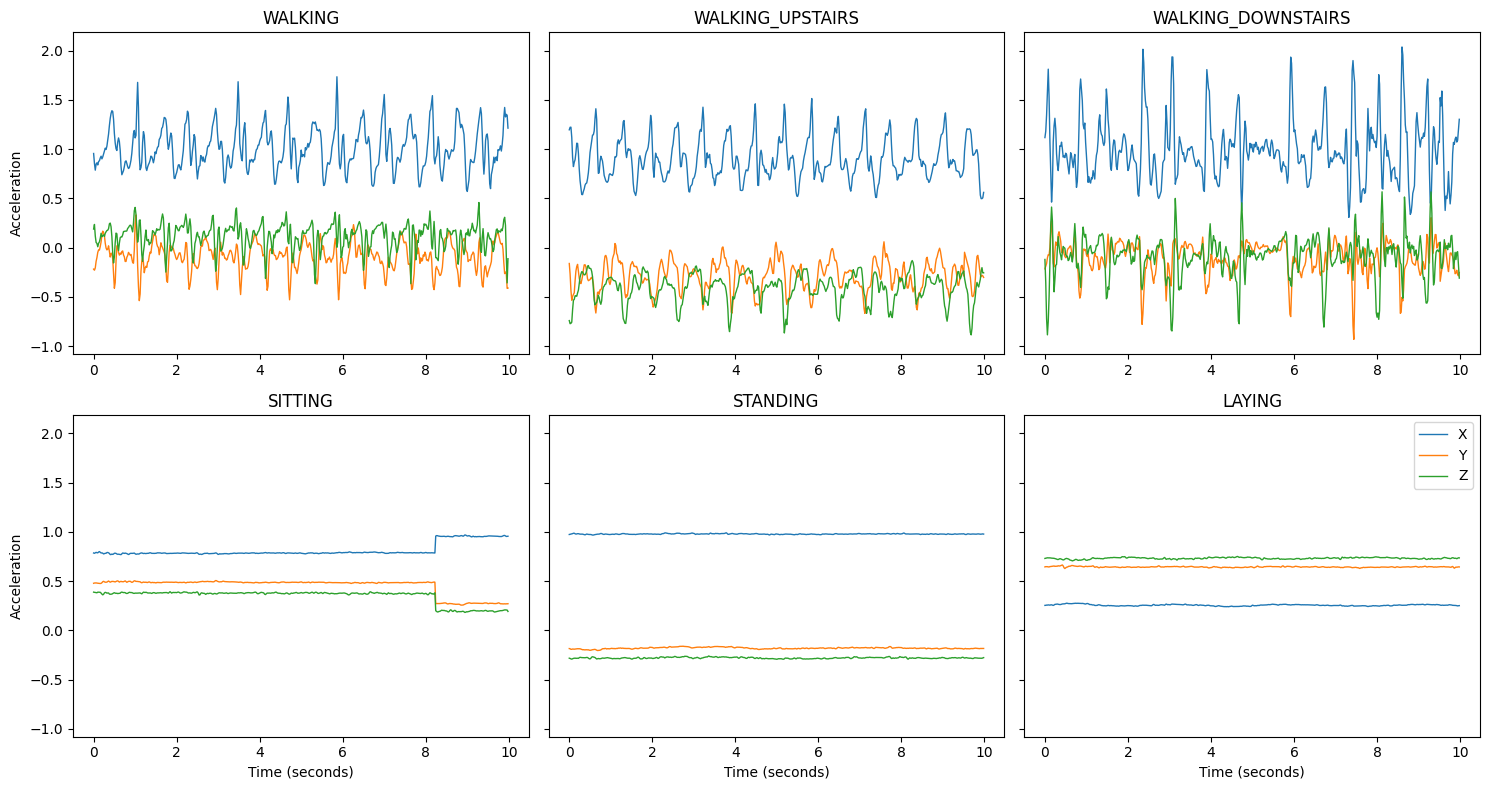

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

fs = 50  # sampling frequency (Hz)
WIN = 128  # UCI-HAR inertial window length; change if yours differs

for i, activity_id in enumerate(activity_labels.keys()):
    # pick one example of this activity
    idxs = np.flatnonzero(y_train == activity_id)
    if idxs.size == 0:
        axes[i].set_title(f"{activity_labels[activity_id]} (no sample)", fontsize=12)
        axes[i].axis("off")
        continue

    sample = X_train[idxs[0]]  # could be (T,C), (C,T), (D,), etc.

    # --- Normalize shape to (T, C) with at least 3 channels (X,Y,Z) ---
    if sample.ndim == 2:
        # Decide whether channels are first or last
        if sample.shape[1] < sample.shape[0]:
            # (T, C)
            T, C = sample.shape
        else:
            # (C, T) -> transpose to (T, C)
            sample = sample.T
            T, C = sample.shape
    elif sample.ndim == 1:
        # Try to recover a (T, C) view from a flattened vector
        D = sample.shape[0]
        if D % WIN == 0:
            C = D // WIN
            sample = sample.reshape(C, WIN).T  # -> (T, C)
            T = WIN
        else:
            # Cannot interpret as time series; skip gracefully
            axes[i].set_title(f"{activity_labels[activity_id]} (not a time series)", fontsize=12)
            axes[i].axis("off")
            continue
    else:
        axes[i].set_title(f"{activity_labels[activity_id]} (unsupported shape)", fontsize=12)
        axes[i].axis("off")
        continue

    # If there are more than 3 channels, use the first three as X,Y,Z
    # (adjust if your XYZ are different columns)
    C_use = min(3, sample.shape[1])
    if C_use < 3:
        axes[i].set_title(f"{activity_labels[activity_id]} (needs ≥3 channels)", fontsize=12)
        axes[i].axis("off")
        continue

    time_axis = np.arange(T) / fs

    axes[i].plot(time_axis, sample[:, 0], label='X', linewidth=1.0)
    axes[i].plot(time_axis, sample[:, 1], label='Y', linewidth=1.0)
    axes[i].plot(time_axis, sample[:, 2], label='Z', linewidth=1.0)

    axes[i].set_title(activity_labels[activity_id], fontsize=12)
    if i % 3 == 0:
        axes[i].set_ylabel("Acceleration")
    if i >= 3:
        axes[i].set_xlabel("Time (seconds)")
    if i == 5:
        axes[i].legend()

plt.tight_layout()
plt.show()


2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer. **[0.5 marks]**

We don’t need a complex machine learning model for this task. For dynamic activities, the linear acceleration shows noticeable fluctuations and high variance. In contrast, for static activities, the linear acceleration remains relatively constant—primarily reflecting gravity with minor noise.

A simple approach would be to set a threshold on the variance of the linear acceleration: if it exceeds the threshold, we classify the activity as dynamic; otherwise, we classify it as static.

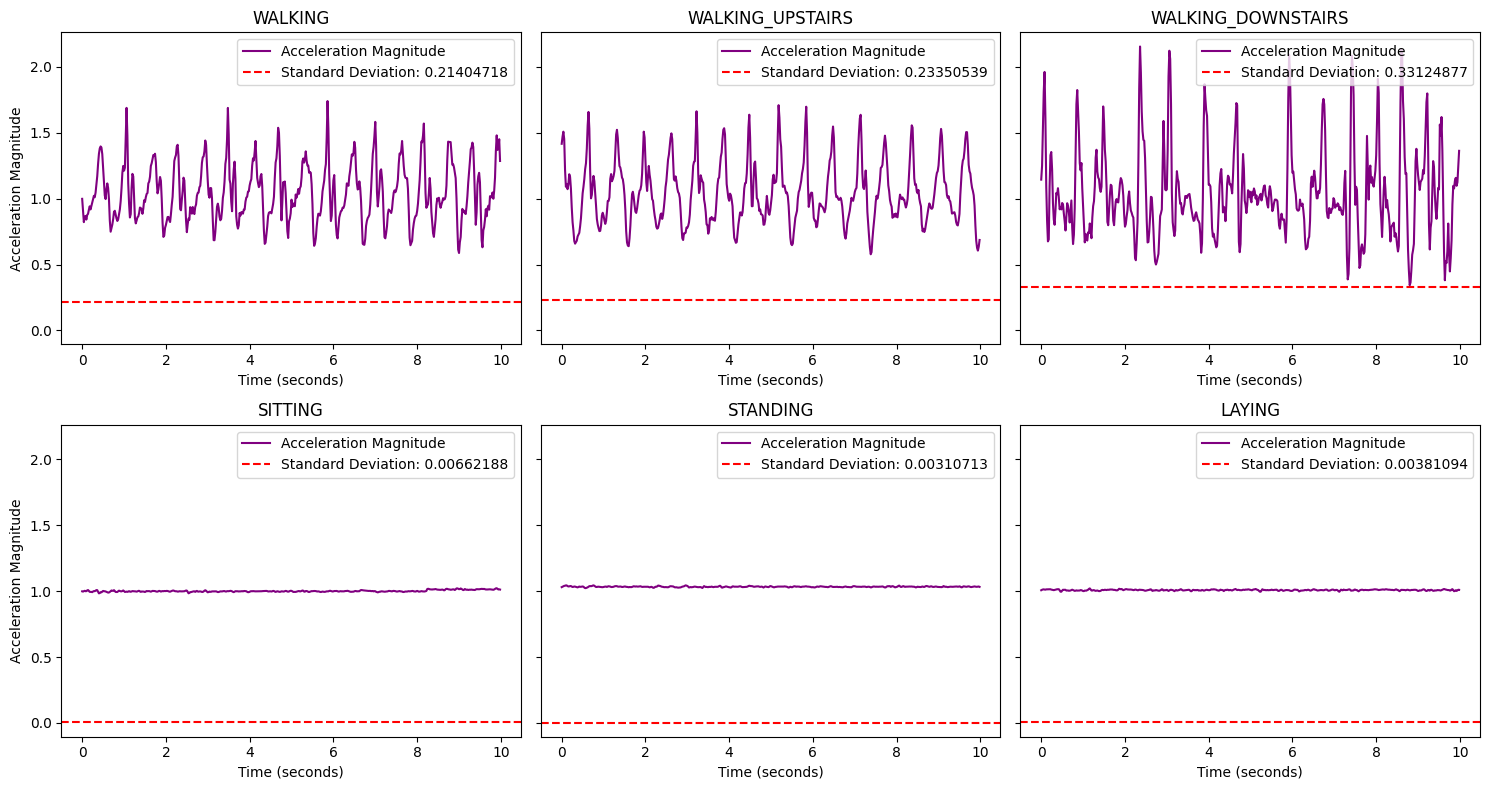

In [58]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

for i, activity_id in enumerate(activity_labels.keys()):
    idx = np.where(y_train == activity_id)[0][0]
    sample = X_train[idx]
    
    # Calculate the acceleration magnitude
    acc_mag = np.sqrt(np.sum(sample**2, axis=1))
    
    # Calculate overall variance of the acceleration magnitude
    overall_variance = np.std(acc_mag)
    
    # Time axis for the plots
    time_axis = np.arange(len(acc_mag)) / 50.0 
    
    # Plot the acceleration magnitude
    axes[i].plot(time_axis, acc_mag, color='purple', label='Acceleration Magnitude')
    
    # Add a horizontal line for the overall variance
    axes[i].axhline(y=overall_variance, color='red', linestyle='--', label=f'Standard Deviation: {overall_variance:.8f}')
    
    axes[i].set_title(activity_labels[activity_id], fontsize=12)
    axes[i].set_xlabel("Time (seconds)")
    
    if i % 3 == 0:
        axes[i].set_ylabel("Acceleration Magnitude")
    
    # Add the legend to each subplot
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()


3. Visualize the data using PCA. **[1 marks]**
* Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

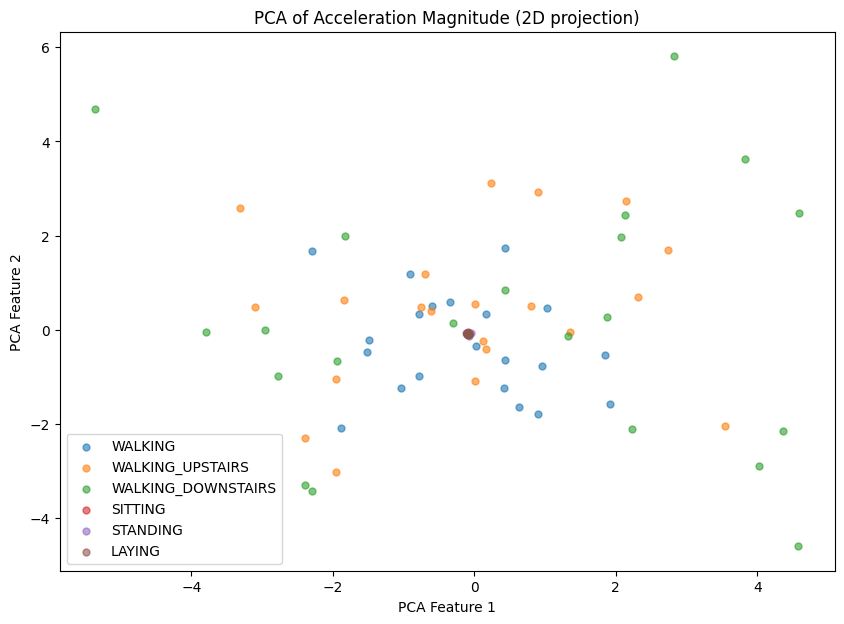

In [59]:
activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

acc_mag = np.sqrt(np.sum(X_train**2, axis=2))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(acc_mag)

plt.figure(figsize=(10, 7))
for activity_id, label in activity_labels.items():
    idx = np.where(y_train == activity_id)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=25, label=label, alpha=0.6)

plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("PCA of Acceleration Magnitude (2D projection)")
plt.legend()
plt.show()

In [60]:
cfg = tsfel.get_features_by_domain("all")
feature_dfs = []
for i in range(X_train.shape[0]):
    mag = np.sqrt(np.sum(X_train[i]**2, axis=1))
    feat_df = tsfel.time_series_features_extractor(cfg, mag, verbose=False)
    feature_dfs.append(feat_df)
X_TSFEL_train = pd.concat(feature_dfs, ignore_index=True)

cfg = tsfel.get_features_by_domain("all")
feature_dfs = []
for i in range(X_test.shape[0]):
    mag = np.sqrt(np.sum(X_test[i]**2, axis=1))
    feat_df = tsfel.time_series_features_extractor(cfg, mag, verbose=False)
    feature_dfs.append(feat_df)
X_TSFEL_test = pd.concat(feature_dfs, ignore_index=True)

KeyboardInterrupt: 

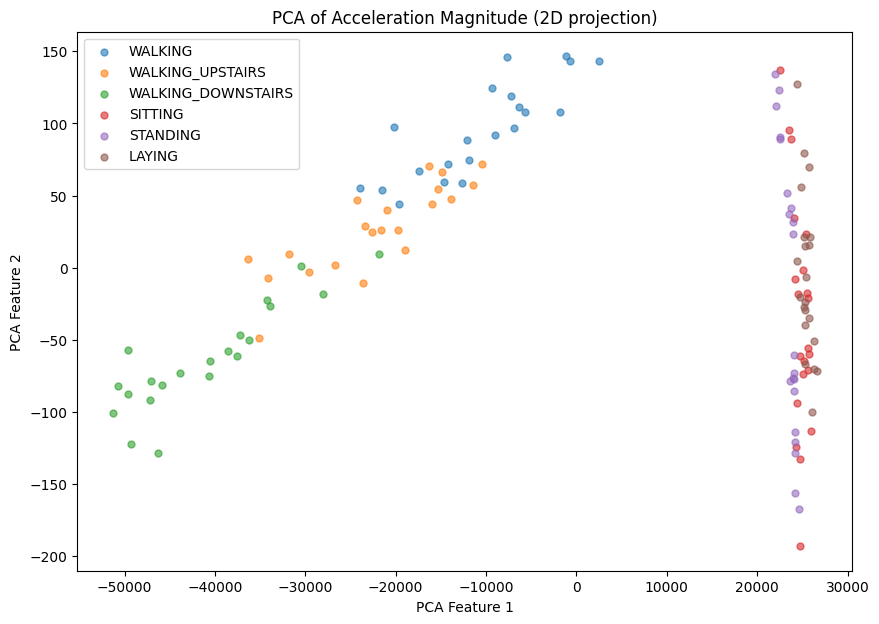

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_TSFEL_train)

plt.figure(figsize=(10, 7))
for activity_id, label in activity_labels.items():
    idx = np.where(y_train == activity_id)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=25, label=label, alpha=0.6)

plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("PCA of Acceleration Magnitude (2D projection)")
plt.legend()
plt.show()

* Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

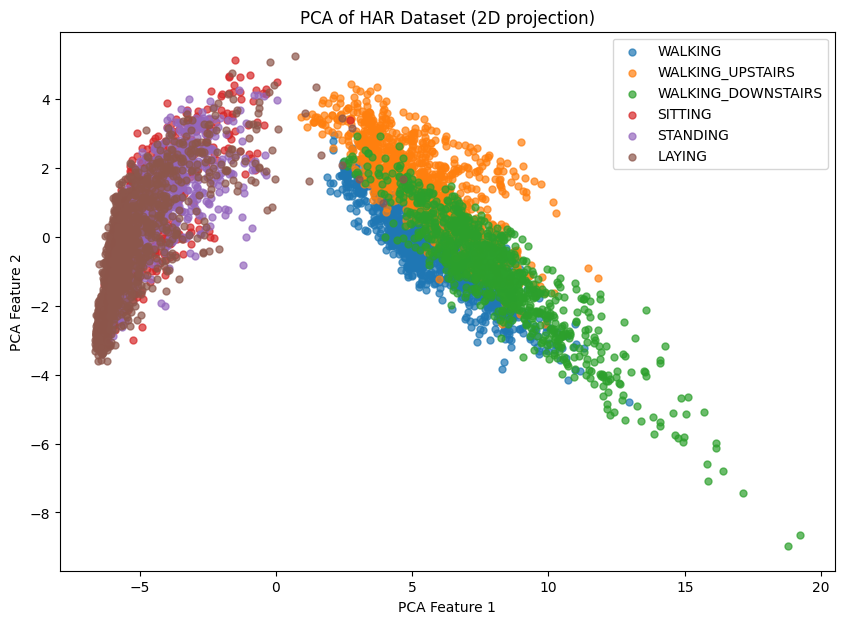

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Feature names
features = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\features.txt", sep='\s+', header=None, usecols=[1])[1].tolist()

# Activity labels
activities = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\activity_labels.txt", sep='\s+', header=None, index_col=0)[1].to_dict()

# features = pd.read_csv(
#     r'C:\Users\user\es335-25-fall-assignment-1\HAR\human activity recognition using smartphones\UCI HAR Dataset\features.txt',
#     sep='\s+', header=None, usecols=[1]
# )[1].tolist()

# activities = pd.read_csv(
#     r'C:\Users\user\es335-25-fall-assignment-1\HAR\human activity recognition using smartphones\UCI HAR Dataset\activity_labels.txt',
#     sep='\s+', header=None, index_col=0
# )[1].to_dict()


# Load train set
X_train_features = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt", sep='\s+', header=None)
y_train_features = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt", sep='\s+', header=None)
X_train_features.columns = features
y_train_features = y_train_features.values.ravel()  # flatten to 1D array
# Load test set
X_test_features = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt", sep='\s+', header=None)
y_test_features = pd.read_csv(r"C:\Users\user\es335-25-fall-assignment-1\HAR\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt", sep='\s+', header=None)
X_test_features.columns = features
y_test_features = y_test_features.values.ravel()  # flatten to 1D array

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_features)

# Plot
plt.figure(figsize=(10, 7))
for activity_id, label in activities.items():
    idx = np.where(y_train_features == activity_id)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=25, label=label, alpha=0.7)

plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("PCA of HAR Dataset (2D projection)")
plt.legend()
plt.show()

* Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

The **dataset-provided features (561 features)** are the best for visualizing activity classes. They give clear, distinct clusters for each activity - walking, sitting, standing, laying, etc. because these features are carefully designed from accelerometer and gyroscope data to capture time, frequency, and cross-axis information.  

TSFEL features are good too, but not as clean, and using only the total acceleration magnitude is too simplistic and overlaps too much.

4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? [1 marks]

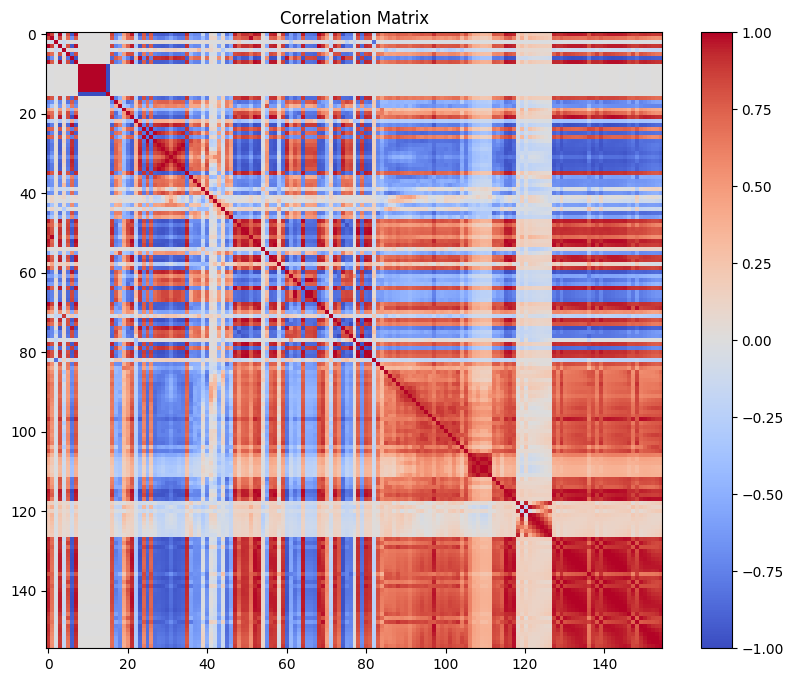

Top 10 correlated Features - 
0_Absolute energy <--> 0_Average power | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_1 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_2 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_3 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_5 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_6 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_7 | correlation: 1.0000
0_ECDF_0 <--> 0_ECDF_8 | correlation: -1.0000
0_ECDF_1 <--> 0_ECDF_2 | correlation: 1.0000
0_ECDF_1 <--> 0_ECDF_3 | correlation: 1.0000


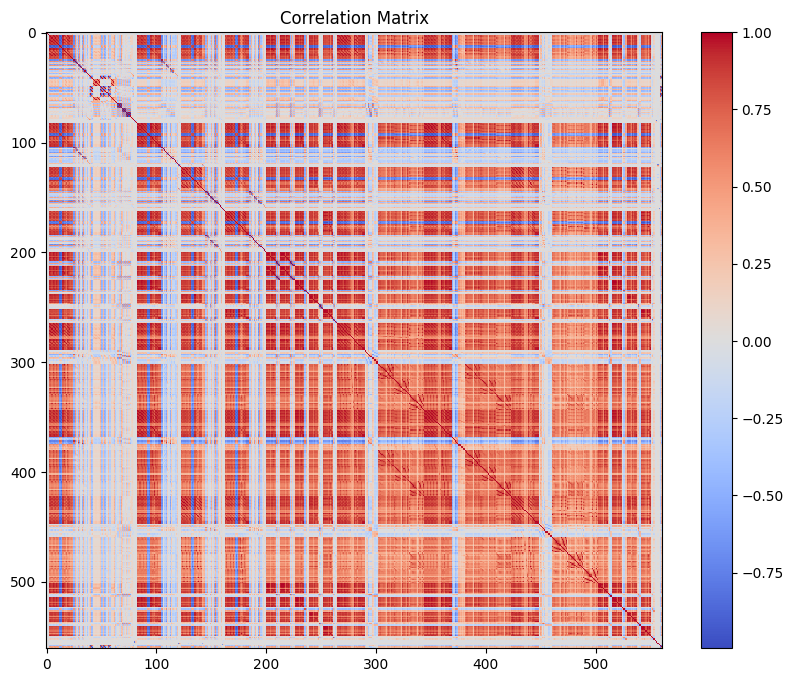

Top 10 correlated Features - 
tBodyAccMag-std() <--> tGravityAccMag-std() | correlation: 1.0000
tBodyAccMag-mad() <--> tGravityAccMag-mad() | correlation: 1.0000
tBodyAccMag-max() <--> tGravityAccMag-max() | correlation: 1.0000
tBodyAccMag-min() <--> tGravityAccMag-min() | correlation: 1.0000
tBodyAccMag-energy() <--> tGravityAccMag-energy() | correlation: 1.0000
tBodyAccMag-iqr() <--> tGravityAccMag-iqr() | correlation: 1.0000
tBodyAccMag-arCoeff()2 <--> tGravityAccMag-arCoeff()2 | correlation: 1.0000
tBodyAccMag-arCoeff()3 <--> tGravityAccMag-arCoeff()3 | correlation: 1.0000
tBodyAccJerkMag-mean() <--> tBodyAccJerkMag-sma() | correlation: 1.0000
tBodyGyroMag-mean() <--> tBodyGyroMag-sma() | correlation: 1.0000


In [ ]:
# X_TSFEL_train, X_train_features
def plot_corr_mat(corr_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title('Correlation Matrix')
    plt.show()

def top_10_correlated_features(X, corr_matrix):
    print("Top 10 correlated Features - ")
    threshold = 0.95
    feature_names = X.columns
    high_corr_pairs = []
    n_features = corr_matrix.shape[0]
    for i in range(n_features):
        for j in range(i + 1, n_features):
            corr_value = corr_matrix[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append((feature_names[i], feature_names[j], corr_value))
    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: -abs(x[2]))
    for f1, f2, corr in high_corr_pairs[:10]:
        print(f"{f1} <--> {f2} | correlation: {corr:.4f}")

# --------------------------------- TSFEL Data ----------------------------------------
stds = np.std(X_TSFEL_train, axis=0)
non_constant_cols = stds > 0
X_TSFEL = X_TSFEL_train.loc[:, non_constant_cols] # remove the columns with 0 std, because data with no variation is almost always useless as it carries no info
corr_matrix = np.corrcoef(X_TSFEL, rowvar=False)
# display(corr_matrix)
plot_corr_mat(corr_matrix)
top_10_correlated_features(X_TSFEL, corr_matrix)

# --------------------------------- HAR Features data --------------------------------- 
corr_matrix = np.corrcoef(X_train_features, rowvar=False)
# print(corr_matrix)
plot_corr_mat(corr_matrix)
top_10_correlated_features(X_train_features, corr_matrix)

There are a lot of features with correlation equal to one, and hence they are highly redundant. After calculating the correlation matrix, it is evident that many features exhibit very high pairwise correlation (close to or exactly 1.0). This indicates a strong linear relationship between those features, meaning they carry overlapping information.

Such redundancy may lead to overfitting and increased computational cost without adding real value to the model.

## Task 2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_data(X_train, X_test, y_train, y_test, depth=None):
    # Initialize classifier with or without max_depth
    params = {"random_state": 42}
    if depth is not None:
        params["max_depth"] = depth
    
    clf = DecisionTreeClassifier(**params)
    
    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    return clf, y_pred

1. Use Sklearn Library to train Decision Tress. [1.5 marks]
* Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def accel_mag(X):
    # X: (n_samples, T, 3) -> (n_samples, T)
    return np.linalg.norm(X, axis=2)

X_train_mag = accel_mag(X_train)
X_test_mag  = accel_mag(X_test)

# Flatten y in case they're column vectors
model1, y_pred = get_data(X_train_mag, X_test_mag, np.ravel(y_train), np.ravel(y_test))

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print("Confusion Matrix:\n", cm)

# Optional: detailed per-class metrics
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy : 0.6481
Precision: 0.6476 (macro)
Recall   : 0.6481 (macro)
Confusion Matrix:
 [[5 1 2 0 1 0]
 [1 5 1 1 0 1]
 [1 4 4 0 0 0]
 [0 0 0 6 0 3]
 [0 0 0 0 9 0]
 [0 0 0 3 0 6]]

Classification report:
               precision    recall  f1-score   support

           1       0.71      0.56      0.62         9
           2       0.50      0.56      0.53         9
           3       0.57      0.44      0.50         9
           4       0.60      0.67      0.63         9
           5       0.90      1.00      0.95         9
           6       0.60      0.67      0.63         9

    accuracy                           0.65        54
   macro avg       0.65      0.65      0.64        54
weighted avg       0.65      0.65      0.64        54



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

model2, y_pred = get_data(X_TSFEL_train, X_TSFEL_test, np.ravel(y_train), np.ravel(y_test))

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)
cm   = confusion_matrix(y_test, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print("Confusion Matrix:\n", cm)

# Optional detailed breakdown
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy : 0.7407
Precision: 0.7545 (macro)
Recall   : 0.7407 (macro)
Confusion Matrix:
 [[6 3 0 0 0 0]
 [1 7 0 0 1 0]
 [0 1 8 0 0 0]
 [0 0 0 5 1 3]
 [0 0 0 2 7 0]
 [0 0 0 2 0 7]]

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.67      0.75         9
           2       0.64      0.78      0.70         9
           3       1.00      0.89      0.94         9
           4       0.56      0.56      0.56         9
           5       0.78      0.78      0.78         9
           6       0.70      0.78      0.74         9

    accuracy                           0.74        54
   macro avg       0.75      0.74      0.74        54
weighted avg       0.75      0.74      0.74        54



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

model3, y_pred = get_data(
    X_train_features, 
    X_test_features, 
    np.ravel(y_train_features), 
    np.ravel(y_test_features)
)

acc  = accuracy_score(y_test_features, y_pred)
prec = precision_score(y_test_features, y_pred, average='macro', zero_division=0)
rec  = recall_score(y_test_features, y_pred, average='macro', zero_division=0)
cm   = confusion_matrix(y_test_features, y_pred)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print("Confusion Matrix:\n", cm)

# Optional: full per-class metrics
print("\nClassification Report:\n", classification_report(y_test_features, y_pred, zero_division=0))


Accuracy : 0.8622
Precision: 0.8625 (macro)
Recall   : 0.8587 (macro)
Confusion Matrix:
 [[456  24  16   0   0   0]
 [ 74 369  28   0   0   0]
 [ 19  53 348   0   0   0]
 [  0   0   0 374 117   0]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]

Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.92      0.87       496
           2       0.83      0.78      0.80       471
           3       0.89      0.83      0.86       420
           4       0.83      0.76      0.80       491
           5       0.80      0.86      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947



Model 3 (Created Features) achieves the strongest performance across all metrics, including accuracy, precision, and recall.

Model 2 (TSFEL) shows clear improvements over Model 1 thanks to richer statistical and spectral features, but it still falls short of Model 3.

Model 1 (Magnitude Only) performs the weakest, highlighting the limitations of relying solely on simple signal magnitude features.

Overall, Model 3 stands out as the best performer, with its superior accuracy (86.2%) as well as higher precision and recall. The use of more advanced features enabled it to distinguish activities much more effectively.

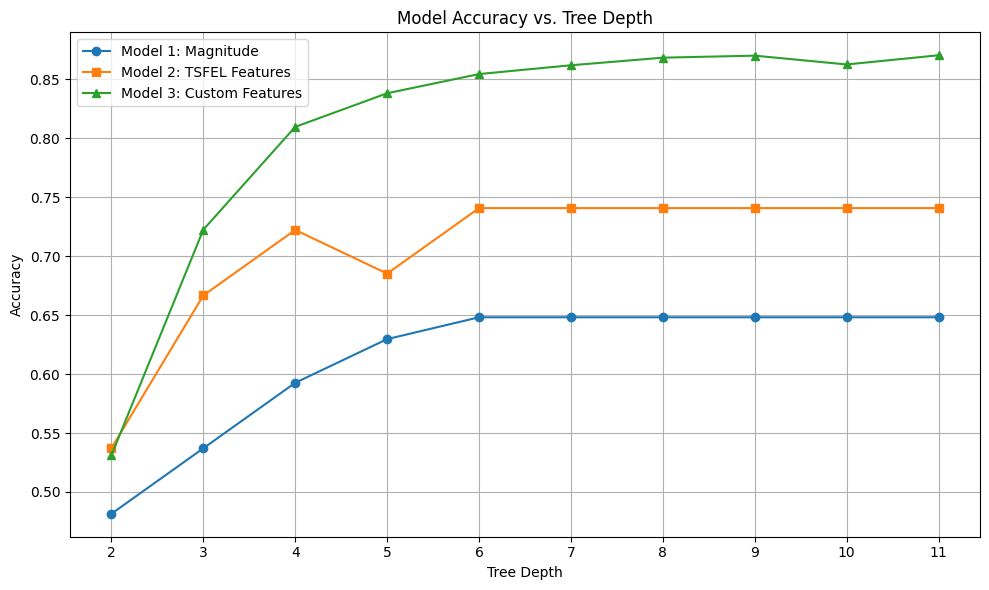

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Helper
def eval_acc(Xtr, Xte, ytr, yte, depth):
    _, y_pred = get_data(Xtr, Xte, np.ravel(ytr), np.ravel(yte), depth)
    return accuracy_score(np.ravel(yte), y_pred)

# Precompute magnitude once (doesn't depend on depth)
X_train_mag = np.linalg.norm(X_train, axis=2)
X_test_mag  = np.linalg.norm(X_test,  axis=2)

depth_range = range(2, 12)
model1_acc, model2_acc, model3_acc = [], [], []

for d in depth_range:
    model1_acc.append(eval_acc(X_train_mag,    X_test_mag,    y_train,          y_test,          d))
    model2_acc.append(eval_acc(X_TSFEL_train,  X_TSFEL_test,  y_train,          y_test,          d))
    model3_acc.append(eval_acc(X_train_features, X_test_features, y_train_features, y_test_features, d))

plt.figure(figsize=(10, 6))
plt.plot(depth_range, model1_acc, marker='o', label='Model 1: Magnitude')
plt.plot(depth_range, model2_acc, marker='s', label='Model 2: TSFEL Features')
plt.plot(depth_range, model3_acc, marker='^', label='Model 3: Custom Features')
plt.xticks(list(depth_range))
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

* The Walking/Walking upstairs and walking downstairs are often confused with each other in almost all the models.
* SITTING is confused with LAYING, STANDING is misclassified as SITTING quite often in all the 3 models.

This is mainly because these activities have
* Similar movement patterns (in dynamic or static states)
* Insufficiently discriminative features

### Analysis of Model Performance

#### 1. Model Using Raw Accelerometer Data
   - Accuracy: 0.351
   - Poor Performance: 
     - Participants 1, 2, 3, 4, and 5: Precision, recall, and F1-scores are very low, with some classes scoring 0.00. 
   - Reasons: Noisy, unprocessed data, feature overlap, and potential class imbalance.

#### 2. Model Using TSFEL Data with PCA
   - Accuracy: 1.0
   - Poor Performance: None; perfect classification.
   - Reasons: High-quality feature extraction and effective dimensionality reduction.

#### 3. Model Using Provided Features Data
   - Accuracy: 0.598
   - Poor Performance:
     - Participants 3, 4, and 5: Moderate performance with precision and recall around 0.60 or lower.
   - Reasons: Possible lack of feature relevance and inter-class feature overlap.

### Conclusion:
- Raw Data: Struggles due to noise and feature overlap.
- TSFEL Data: Performs perfectly due to well-engineered features and PCA.
- Provided Features: Moderate performance, with room for improvement in feature selection and engineering.

### Task 3

In [ ]:
import os



In [ ]:
from scipy.interpolate import interp1d

# Constants
time = 10
offset = 500
freq = 50
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

X_Custom=[]
y_Custom=[]
dataset_dir = os.path.join("..", "Custom Input Data")


def resampleAt50(df):
    df = df.copy()
    df = df.sort_values('time')  # ensure time is sorted
    df = df.set_index('time')
    t_min = df.index.min()
    t_max = df.index.max()
    new_time = np.arange(t_min, t_max, 1/freq)  # 50 Hz => step of 0.02s
    interp_df = pd.DataFrame({'time': new_time})
    for col in df.columns:
        f = interp1d(df.index, df[col], kind='linear', fill_value="extrapolate")
        interp_df[col] = f(new_time)
    # interp_df.set_index('time', inplace=True)
    return interp_df

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir,folder))

    for file in files:

        df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
        df = resampleAt50(df)
        df = df.iloc[:, [1, 2, 3]]
        if len(df) < offset+time*freq:
            continue
        df = df[offset:offset+time*freq]
        X_Custom.append(df.values)
        y_Custom.append(classes[folder])
X_Custom = np.array(X_Custom)
y_Custom = np.array(y_Custom)
# print(X_Custom.shape)

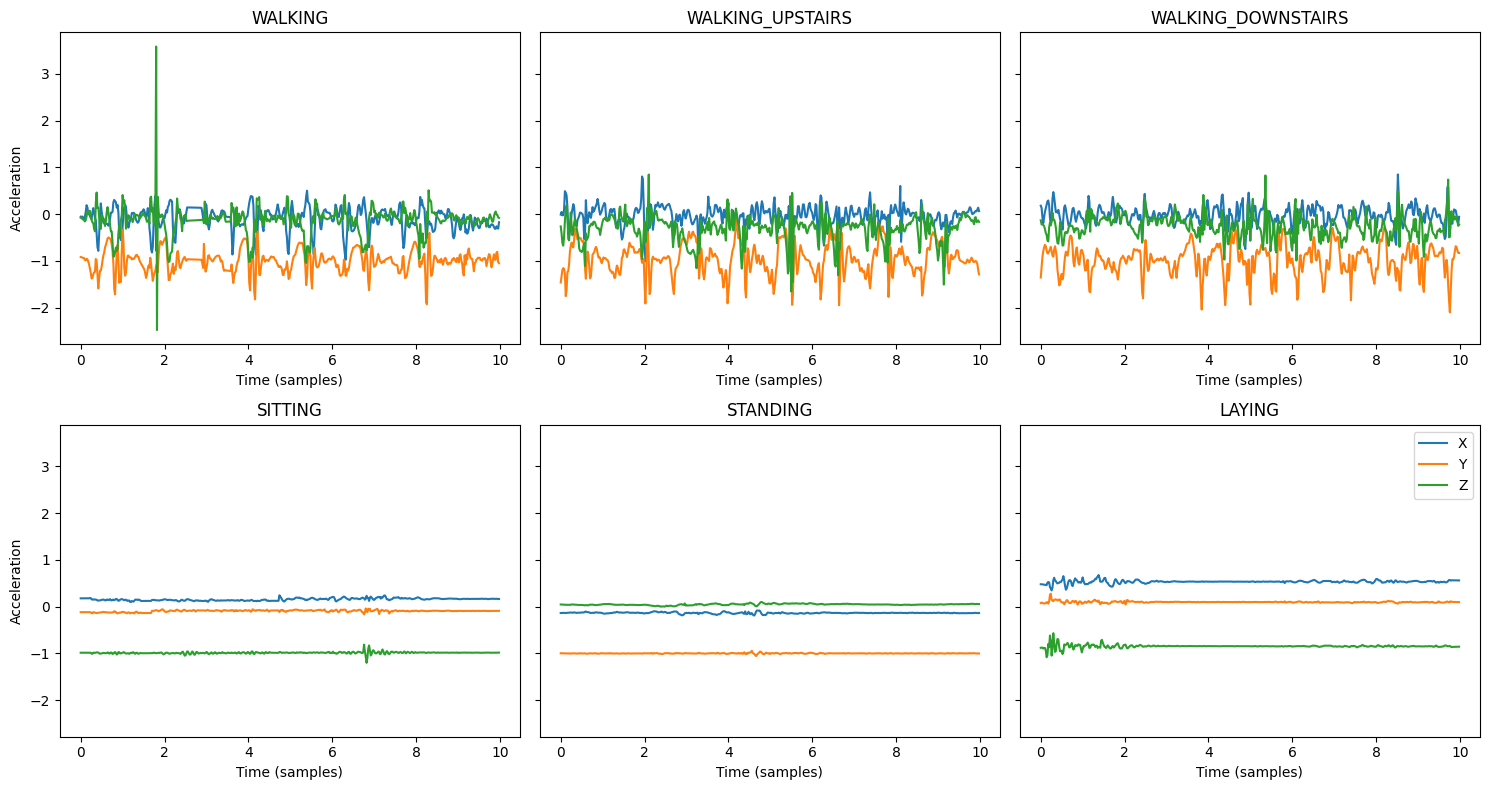

In [ ]:
activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.ravel()

for i, activity_id in enumerate(activity_labels.keys()):
    idx = np.where(y_Custom == activity_id)[0][0] # get any of such index
    sample = X_Custom[idx] # sample of activity where activity == i
    
    time_axis = np.arange(500) / 50.0 # data is on 50 Hz, so time will be 0, 1/50, 2/50, 3/50 ... seconds
    axes[i].plot(time_axis, sample[:, 0], label='X')
    axes[i].plot(time_axis, sample[:, 1], label='Y')
    axes[i].plot(time_axis, sample[:, 2], label='Z')
    axes[i].set_xlabel("Time (seconds)")
    
    axes[i].set_title(activity_labels[activity_id], fontsize=12)
    axes[i].set_xlabel("Time (samples)")
    
    if i % 3 == 0:
        axes[i].set_ylabel("Acceleration")
    if i == 5:
        axes[i].legend()

plt.tight_layout()
plt.show()

1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

Generating the 561 features provided by the author for my collected data is very difficult, so that option is currently ruled out. Since the TSFEL model performed better overall in my previous tests, I will be using the TSFEL model exclusively by generating similar features on the collected data, consistent with the trained model.

In [ ]:
# feature extraction using TSEFL
cfg = tsfel.get_features_by_domain("all")
feature_dfs = []
for i in range(X_Custom.shape[0]):
    mag = np.sqrt(np.sum(X_Custom[i]**2, axis=1))
    feat_df = tsfel.time_series_features_extractor(cfg, mag, verbose=False)
    feature_dfs.append(feat_df)
X_Custom_TSFEL = pd.concat(feature_dfs, ignore_index=True)

# Results
y_pred = model2.predict(X_Custom_TSFEL)
print(f"Accuracy: {accuracy_score(y_Custom, y_pred)}")
print(f"Precision: {precision_score(y_Custom, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_Custom, y_pred, average='macro')}")
print("Confusion Matrix:")
print(confusion_matrix(y_Custom, y_pred))

Accuracy: 0.391304347826087
Precision: 0.2341269841269841
Recall: 0.38888888888888884
Confusion Matrix:
[[4 0 0 0 0 0]
 [3 0 1 0 0 0]
 [0 0 1 0 0 2]
 [0 0 0 0 0 4]
 [0 0 0 2 0 2]
 [0 0 0 0 0 4]]


2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? [1 marks]

A number of preprocessing were done, which include
- The data was resampled to 50 Hz to match the sampling rate of the UCI-HAR dataset, as the phone originally recorded data at approximately 200 Hz.  
- The beginning and end of the recordings were trimmed to eliminate noise and retain only the most relevant segment of the activity.  
- Feature extraction was performed using TSFEL to ensure the data format and features aligned with those used in the TSFEL-trained model.

In [51]:
# feature extraction using TSEFL
cfg = tsfel.get_features_by_domain("all")
feature_dfs = []
for i in range(X_Custom.shape[0]):
    mag = np.sqrt(np.sum(X_Custom[i]**2, axis=1))
    feat_df = tsfel.time_series_features_extractor(cfg, mag, verbose=False)
    feature_dfs.append(feat_df)
X_Custom_TSFEL = pd.concat(feature_dfs, ignore_index=True)

# Results
y_pred = model2.predict(X_Custom_TSFEL)
print(f"The perfomance of the model with featuraization using TSFEL")
print(f"Accuracy: {accuracy_score(y_Custom, y_pred)}")
print(f"Precision: {precision_score(y_Custom, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_Custom, y_pred, average='macro')}")
print("Confusion Matrix:")
print(confusion_matrix(y_Custom, y_pred))

The perfomance of the model with featuraization using TSFEL
Accuracy: 0.4782608695652174
Precision: 0.45555555555555555
Recall: 0.4861111111111111
Confusion Matrix:
[[2 1 1 0 0 0]
 [0 1 3 0 0 0]
 [0 0 4 0 0 0]
 [0 0 0 2 0 2]
 [0 0 0 3 0 1]
 [0 0 0 1 0 2]]


In [61]:
# Using raw data from accelerometer
X_Custom_mag = np.sqrt(np.sum(X_Custom**2, axis=2))
y_pred = model1.predict(X_Custom_mag)
print(f"The perfomance of the model without featurization etc. on raw data")
print(f"Accuracy: {accuracy_score(y_Custom, y_pred)}")
print(f"Precision: {precision_score(y_Custom, y_pred, average='macro')}")
print(f"Recall: {recall_score(y_Custom, y_pred, average='macro')}")
print("Confusion Matrix:")
print(confusion_matrix(y_Custom, y_pred))

The perfomance of the model without featurization etc. on raw data
Accuracy: 0.5217391304347826
Precision: 0.41111111111111115
Recall: 0.5138888888888888
Confusion Matrix:
[[0 4 0 0 0 0]
 [0 2 2 0 0 0]
 [0 0 1 0 2 0]
 [0 0 0 4 0 0]
 [0 0 0 2 1 1]
 [0 0 0 0 0 4]]
